# Exercise Sheet 3: Neural Networks 2

In [6]:
import numpy as np
import time
from matplotlib import pyplot as plt

def logistic(h,a=1):
    return 1/(1+np.exp(-a*h))
dlogistic=lambda x: logistic(x)-np.power(logistic(x),2)
signtrafunc=lambda x: (np.sign(x)+1)/2


In [2]:
import Exercise3helper36 as helper

## Task 1 Lateral Inhibition  (4  points - programming)
Build a network layer representing the simple lateral inhibition we have faced in lecture 2. This involves only a direct neighbour supression. It represents a not fully-connected MLP layer. The layer should be 10 neurons wide.
Set the bias to $b=0$ and the neighbour weights to $w=-0.25$. Later, repeat the simulation with $w=-0.5$.

As inputs, use a random vector of 0 and 1 (np.random.randi).

First solve the task with the logistic transfer function. Then use the sign-based transfer function and examine the results with plots.

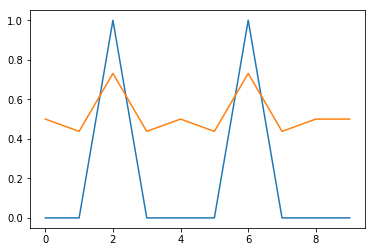

In [210]:
class neuron:    
    
    def __init__(self,w,b=0,trafunc=logistic,dtrafunc=dlogistic):
        self.w=np.array(w)
        self.b=np.array(b)
        self.trafunc=trafunc
        self.dtrafunc=dtrafunc
        
    def out(self, x):
        return self.trafunc(np.dot(self.w,x)-self.b)   
    
class LateralInhibitionLayer:
    
    def __init__(self, weight_inhibition, weightinit=1,b = 0,trafunc=logistic,dtrafunc=dlogistic):
        self.neurons = []
        self.neurons.append(neuron( [weightinit, weight_inhibition], b, trafunc=trafunc,dtrafunc= dtrafunc))   
        for i in range(8):
             self.neurons.append(neuron( [weight_inhibition, weightinit, weight_inhibition], b, trafunc=trafunc,dtrafunc= dtrafunc))   
        self.neurons.append(neuron( [weight_inhibition, weightinit], b, trafunc=trafunc,dtrafunc= dtrafunc))   
        
    def out(self,x):
        returnobj = np.zeros(len(self.neurons))
        for n in range(len(self.neurons)):
            
            #if first one\
            if n == 0:
                returnobj[n] = (self.neurons[n].out([x[n], x[n+1]]))
            #if last one
            elif n == len(self.neurons)-1:
                returnobj[n] = (self.neurons[n].out([x[n-1], x[n]]))
            #if not, ask the neighbours len - 1 and len +1
            else:
                returnobj[n] = (self.neurons[n].out([x[n-1], x[n], x[n+1]]))
        
        return returnobj
    
#logistic function -0.25
layer_traf = LateralInhibitionLayer(-0.25)
x = x=np.random.randint(2,size=10)
plt.plot(x)
plt.plot(layer_traf.out(x))


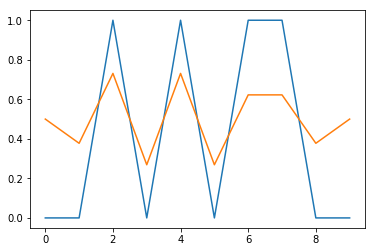

In [211]:
#logistic function -0.5
layer_traf = LateralInhibitionLayer(-0.5)
x = x=np.random.randint(2,size=10)
plt.plot(x)
plt.plot(layer_traf.out(x))

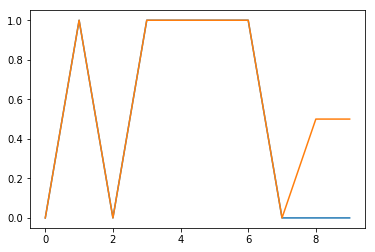

In [212]:
#Sign based function -0.25
layer_sign = LateralInhibitionLayer(-0.25, trafunc=signtrafunc)
x = x=np.random.randint(2,size=10)
plt.plot(x)
plt.plot(layer_sign.out(x))

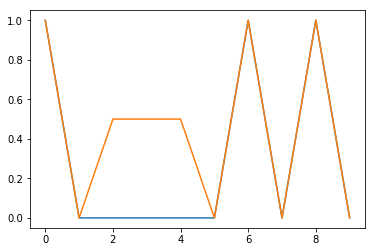

In [213]:
#Sign based function -0.5
layer_sign = LateralInhibitionLayer(-0.5, trafunc=signtrafunc)
x = x=np.random.randint(2,size=10)
plt.plot(x)
plt.plot(layer_sign.out(x))

## Task 2 Lateral Inhibition: trained (2 points - programming)
Use the output of the lateral inhibition layer as a target output for an MLP with 1 layers of 10 neurons.
Try out both tranfer functions for the lateral inhibition layer (target) but only the logistic for training the MLP. Use $w=-0.25$ for the inhibition.

Determine a number of iterations that you decide to be enough for the network to have converged.

Measure the execution time by using the python module time and time.time() to get the current time. Also, investigate the weights after initialization and after the last iteration.

If you haven't solved task 1, you can use the class *LateralInhibitionLayer(NodeNo,Neighbourweight,bias=0,trafunc=logistic)* from the Exercise3Helper with the method LateralInhibitionLayer.out(x) as the target function.

0.257004976272583


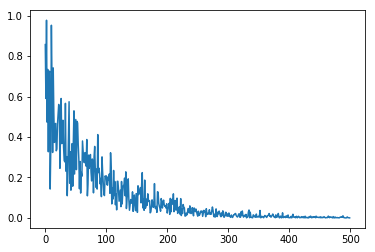

In [214]:
#with logistic
layer = LateralInhibitionLayer(-0.25)
x = x=np.random.randint(2,size=(500,10))
o = []
for n in range(500):
    o.append(layer.out(x[n]))

mlp = helper.MLP(10, 10)
t1 = time.time()
#check weight before
plt.plot(mlp.train(NumIt=500,learnrate=1,x_train=x, o_train=o))
#check weight after
t2 = time.time()
print(t2 - t1)

0.2648780345916748


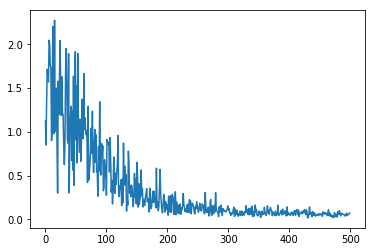

In [215]:
layer = LateralInhibitionLayer(-0.25, trafunc=signtrafunc)
x = x=np.random.randint(2,size=(500,10))
o = []
for n in range(500):
    o.append(layer.out(x[n]))

mlp = helper.MLP(10, 10)
t1 = time.time()
#check weight before
plt.plot(mlp.train(NumIt=500,learnrate=1,x_train=x, o_train=o))
#check weight after
t2 = time.time()
print(t2 - t1)

## Task 3 1D-Convolutional NN layer (5 points - programming)
Build a 1-dimensional convolutional neural layer that can be trained with gradient descent and included as a layer into the MLP class from sheet 2.

To this extent, you combine the classes of single neurons and MLP layers into one that has one set of weights and a bias for the whole layer.

In the out function, it performs a convolution ($*$) of the input with the weights 
(np.convolve(x,w,mode='same')), subtracts the bias and calculates the transferfunction of the result: $\mathbf{y}=f(\mathbf{w} * \mathbf{x} - b)=f(\mathbf{h})$.

The derivative of this is needed for the gradient descent training of the weights and the bias. For the single weights in an output layer, it becomes: $\frac{d{\mathbf{y}}}{dw_i}=\frac{df({\mathbf{h}})}{d\mathbf{h}} \frac{d\mathbf{h}}{d\mathbf{x}}=f'({\mathbf{h}}) \odot  e_i * x$. Introducing $\mathbf{d}_i:= \mathbf{e}_i *\mathbf{x}$, we can reach a squite simple formula for the weight updates. $\mathbf{e}_i$ is the unit vector, where entry $i$ is 1 and all others are 0.

This leads to the following weight and bias update rules, implemented in a *train(deltanext, weightsnext,...)* fuction similar to the perceptron:

$w_i(t+1)=w_i(t)-\eta \sum_k (y_k-o_k) f'(h_k)  (\mathbf{d}_i)_{(k)}$

$b(t+1)=b(t)+\eta \sum_k (y_k-o_k) f'(h_k)$.

$(\mathbf{d}_i)_{(k)}$ is the $k$th element of $\mathbf{d}_i$.

If we use a local error gradient $\delta_{l}$ for the CNN layer l $\delta_{l} = f'(\mathbf{h}_l) \mathbf{W}_{l+1} \delta_{l+1}$ equivalent to that of a perceptron (lecture 2 slide 47), the columns i of the weightsnext matrix $\mathbf{W}_l$ for the layer before can be written as $[\mathbf{W}_l]_{(i)}=\mathbf{e}_i*\mathbf{w}$. To make it simpler, the weightsnext W returned by train are:

*WE=np.eye(len(self.lastin))*

*W=np.array([np.convolve(we,self.w,mode='same') for we in WE])*.

The weight update rule for any CNN layer l become:

$w_i(t+1)=w_i(t)-\eta \sum_k [\delta_{l+1}]_{(k)} [\mathbf{W}_{l+1}]_{(k)} f'(h_k)  (\mathbf{d}_i)_{(k)}$

$b(t+1)=b(t)+\eta \sum_k [\delta_{l+1}]_{(k)} [\mathbf{W}_{l+1}]_{(k)}  f'(h_k)$.

Note that $\mathbf{y}$,$\mathbf{h}_l$, $[\mathbf{W}_{l+1}]_{(k)}$, and $\delta_l$ have all the same dimensionality as the input $\mathbf{x}$.

In [626]:
class CNNlayer:
    
    def __init__(self,Filterwidth,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=logistic,dtrafunc=dlogistic):
        self.Filterwidth = Filterwidth
        self.w = weightinit(Filterwidth)
        self.b = biasinit(1)
        self.trafunc = trafunc
        self.dtrafunc = dtrafunc
       
    def out(self,x):
        self.lastin = x
        self.lasth = np.convolve(self.w, x, mode='same') - self.b
        self.lastout = self.trafunc(self.lasth)
        return self.lastout
    
    def delta(self, deltanext, weightsnext):
        self.lastdelta = self.dtrafunc(self.lasth) * np.dot(deltanext, weightsnext)
        return self.lastdelta
    
    def train(self,deltanext,W,learnrate=0.1):    
        self.lastdelta = self.delta(deltanext, W)            
        for i in range(len(self.w)):
            ei = np.zeros(len(self.w)).astype(int)
            ei[i] = 1
            Di = np.convolve(ei , self.lastin, mode="same")
            errorgradient_di = sum(self.lastdelta * Di)
            self.w[i] = self.w[i] - learnrate*errorgradient_di
        self.b = self.b + learnrate * sum(self.lastdelta)
        WE = np.eye(len(self.lastin))
        Wreturn = np.array([np.convolve(we, self.w, mode='same') for we in WE])
        return self.lastdelta, Wreturn

## Task 4 Training a 1D-Convolutional NN on lateral inhibition (2 points - programming)

Use the output of the lateral inhibition layer as a target output for a CNN consisting of 1 layer with 10 neurons. You can simnply abuse the MLP class and assign a single layer using the CNNlayer class. Use $w=-0.25$ for the inhibition.

Measure and compare the execution time to the one of the MLP trained on the same problem (Task 3) by using the python module time and time.time() to get the current time.  Use the same number of intializations. Also, investigate the weights after initialization and after the last iteration.

If you haven't solved task 1, you can use the class *LateralInhibitionLayer(NodeNo,Neighbourweight,bias=0,trafunc=logistic)* from the Exercise3Helper with the method LateralInhibitionLayer.out(x) as the target function. Similarly, if you haven't solved task 3, you can use the class *CNNlayer(Filterwidth, weightinit=np.random.randn, biasinit=np.random.randn, trafunc=logistic, dtrafunc=dlogistic)* of the helper for the layer.


In [627]:
# This should converge faster than before
cnnlayer = CNNlayer(10)

cnnlayer.out([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
cnnlayer.train([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
print(cnnlayer.w)


[-2.83946472 -0.90299769 -1.15364343  0.71093894 -0.87842594 -1.36037165
  0.6298553  -1.10116096 -1.86800765 -1.58139399]


## Task 5 Local Oscilations (2 points - programming)
Rewrite the neuron class below to receive a neuron with local feedback capable of oscillations. This will be a very simple example to demonstrate oscillations, biologically not very plausible as we e.g. don't include the refactory period.

To this extent, you need to save and feedback the last output in a certrain time interval. No training or delta functions are necessary. The output function becomes:
$y(t)=f(w\cdot x(t)+w_\tau y(t-\tau)-b)$

Initialize a regular perceptron and a local feedback neuron with the same weights and feed them the same random inputs for 200 iterations. The input should be of shape (2,), randomly distributed with an average of 0.5 and a standard deviation of 0.2.
Repeat the 200 iterations each with every possible combination of the following parameters: $\tau=\{10,5\}$ and $w_\tau=\{10,5,1,-1,-5,-10\}$.


In [ ]:
w_taus=[10,5,1,-1,-5,-10]
taus=[10,5]
